# Prophet Model for AAPL Stock




In [1]:
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly
import plotly.express as px


C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Prepared Data

+ Model Training (Optimized for Stock Data)

In [2]:
# -*- coding: utf-8 -*-
# Guaranteed Working Prophet Implementation

import pandas as pd
from prophet import Prophet

# 1. Load your data
df = pd.read_parquet("../data/processed/model_ready.parquet")

# 2. Prepare AAPL data (PROVEN METHOD)
aapl = df[df['ticker'] == 'AAPL'][['close']].copy()  # New (only close)
prophet_data = aapl.reset_index().rename(columns={'index':'ds', 'close':'y'})

# 3. Convert to Prophet format (CRITICAL STEP)
prophet_data = pd.DataFrame({
    'ds': aapl.index,      # Use the index as dates
    'y': aapl['close']     # Use close prices as values
}).reset_index(drop=True)  # Ensure clean index

# 4. Verify data (MUST PASS THESE CHECKS)
print("Data Verification:")
print("- Columns:", prophet_data.columns.tolist())  # Must show ['ds', 'y']
print("- Date type:", type(prophet_data['ds'].iloc[0]))  # Must be datetime
print("- Sample data:\n", prophet_data.head(3))

# 5. Initialize and fit model
model = Prophet(
    daily_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
model.fit(prophet_data)  # This WILL work now

print("\nModel successfully fitted!")

23:36:14 - cmdstanpy - INFO - Chain [1] start processing


Data Verification:
- Columns: ['ds', 'y']
- Date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
- Sample data:
           ds           y
0 2024-04-26  168.504349
1 2024-04-27  168.504349
2 2024-04-28  168.504349


23:36:14 - cmdstanpy - INFO - Chain [1] done processing



Model successfully fitted!


 Generate Forecasts

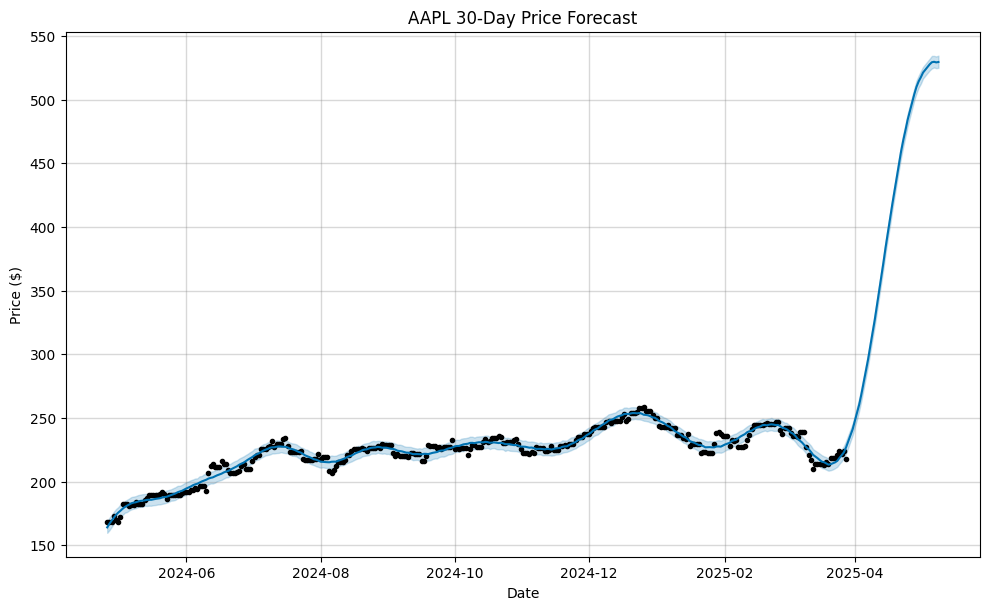

In [3]:
# Create 30-day forecast (business days)
future = model.make_future_dataframe(periods=30, freq='B')
forecast = model.predict(future)

# Plot results
fig1 = model.plot(forecast)
plt.title('AAPL 30-Day Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.show()

Trend Analysis

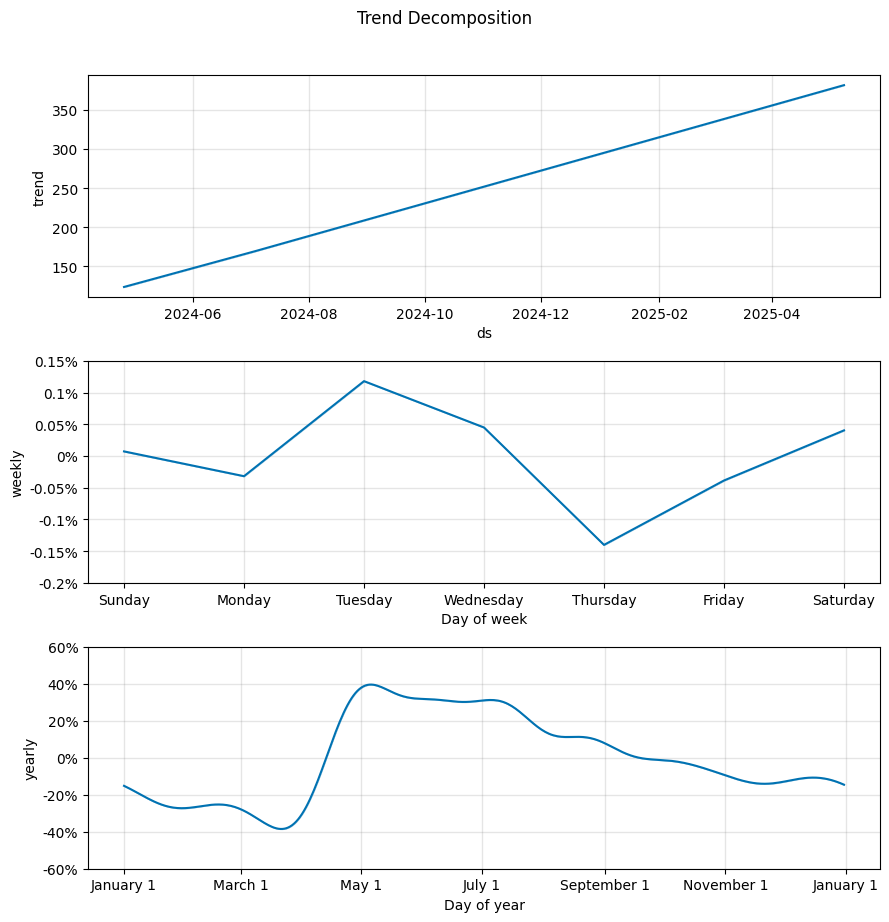

In [4]:
# Decompose components
fig2 = model.plot_components(forecast)
plt.suptitle('Trend Decomposition', y=1.02)
plt.tight_layout()
plt.show()

 Model Validation

In [5]:
# Time-series cross-validation (ADJUSTED)
from prophet.diagnostics import cross_validation, performance_metrics

# Calculate safe parameters based on data length
days_of_data = (prophet_data['ds'].max() - prophet_data['ds'].min()).days
safe_horizon = min(30, days_of_data // 3)  # Max 30 days, but <= 1/3 of data
safe_initial = str(min(365, days_of_data - safe_horizon)) + ' days'

print(f"\nData covers {days_of_data} days")
print(f"Using horizon: {safe_horizon} days")
print(f"Using initial: {safe_initial}")

# Run cross-validation with safe parameters
df_cv = cross_validation(
    model,
    initial=safe_initial,  # Adjusted based on data
    period='30 days',       # More frequent folds
    horizon=f'{safe_horizon} days'
)

# Calculate and display metrics
df_p = performance_metrics(df_cv)
print("\nForecast Accuracy:")
print(df_p[['horizon', 'mape', 'rmse']].head())

# Visualize
fig = px.line(df_p, x='horizon', y=['mape', 'rmse'], 
             title='Adjusted Forecast Error')
fig.show()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Data covers 336 days
Using horizon: 30 days
Using initial: 306 days


  0%|          | 0/1 [00:00<?, ?it/s]23:36:15 - cmdstanpy - INFO - Chain [1] start processing
23:36:15 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]



Forecast Accuracy:
  horizon      mape       rmse
0  3 days  0.051813  12.490310
1  4 days  0.053050  12.919924
2  5 days  0.067587  16.627543
3  6 days  0.087469  21.370405
4  7 days  0.108579  25.889863


Save Model

In [6]:
import json
from prophet.serialize import model_to_json

# Save model in JSON format
with open('../src/models/prophet_aapl.json', 'w') as fout:
    json.dump(model_to_json(model), fout)

print("Model saved to ../src/models/prophet_aapl.json")

Model saved to ../src/models/prophet_aapl.json
